In [6]:
from astropy.io import fits
from astropy.table import Table

import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt

In [7]:
G = 6.674e-11 # m^3 kg^-1 s^-2
c = 3e5 # km/s
Msun = 1.989e30 # kg

h = 1
H0 = 100*h # km/s/Mpc

# Import galaxy data

In [8]:
galaxy_ID = '9031-3701'

plate, fiber = galaxy_ID.split('-')
galaxy_data = fits.open('../data/MaNGA/MaNGA_DR16/HYB10-GAU-MILESHC/' + plate + '/manga-' 
                        + galaxy_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz')

# Extract H-alpha velocity map (C19)
Ha_vel = galaxy_data['EMLINE_GVEL'].data[18]

# H-alpha mask extension
Ha_mask_extension = galaxy_data['EMLINE_GVEL'].header['QUALDATA']

# Extract stellar velocity map
star_vel = galaxy_data['STELLAR_VEL'].data

# Stellar velocity mask extension
star_vel_mask_extension = galaxy_data['STELLAR_VEL'].header['QUALDATA']

# Extract (and correct for instrumental resolution effects) stellar velocity dispersion map
star_sigma = np.sqrt(galaxy_data['STELLAR_SIGMA'].data**2 
                     - galaxy_data['STELLAR_SIGMACORR'].data**2)
# See https://www.sdss.org/dr16/manga/manga-data/working-with-manga-data/ for correction 
# details

# Stellar velocity dispersion mask extension
star_sigma_mask_extension = galaxy_data['STELLAR_SIGMA'].header['QUALDATA']

# Extract stellar mass density map
#sMass_density = galaxy_data[1].data[19]

# Extract average mass-to-light ratio map
#MtoL = galaxy_data[1].data[17]

# Extract average r-band image
r_band = galaxy_data['SPX_MFLUX'].data

In [9]:
'''
master_filename = '../master_file.txt'

general_data = Table.read(master_filename, format='ascii.ecsv')
'''

drp_filename = '../data/MaNGA/drpall-v2_4_3.fits'

general_data = fits.open(drp_filename)

In [24]:
general_data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1340 / length of dimension 1                          
NAXIS2  =                11465 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   99 / number of table fields                         
TTYPE1  = 'plate   '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'ifudsgn '                                                            
TFORM2  = '21A     '                                                            
TTYPE3  = 'plateifu'        

In [20]:
general_data[1].data['nsa_elpetro_th50_r']

general_data[1].data['plateifu']

#general_data[1].data['nsa_elpetro_absmag'][4]

chararray(['8935-12701', '9118-12701', '7977-12701', ..., '8719-9102',
           '8718-9102', '9288-9102'], dtype='<U11')

# Mask "bad" data

H$\alpha$ velocity map

In [10]:
mHa_vel = ma.array(Ha_vel, mask=galaxy_data[Ha_mask_extension].data[18]>0)

Ha_vel_max = np.max(np.abs(mHa_vel))

DAP stellar velocity map

In [11]:
mStar_vel = ma.array(star_vel, mask=galaxy_data[star_vel_mask_extension].data>0)

star_vel_max = np.max(np.abs(mStar_vel))

DAP stellar velocity dispersion map

In [12]:
mStar_sigma = ma.array(star_sigma, mask=galaxy_data[star_sigma_mask_extension].data>0)

mStar_sigma = ma.masked_invalid(mStar_sigma)

In [13]:
mr_band = ma.masked_equal(r_band, 0)

# Plot velocity map

Text(0, 0.5, '$v_*$ [km/s]')

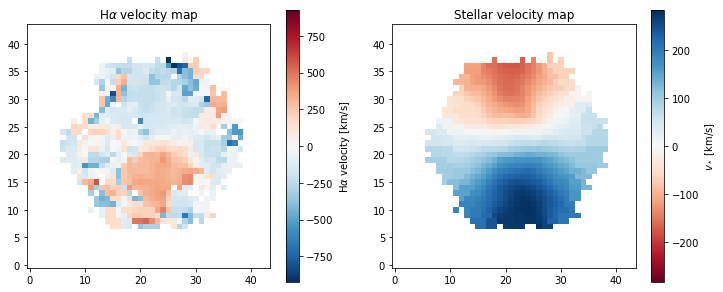

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title(r'H$\alpha$ velocity map')
plt.imshow(mHa_vel, cmap='RdBu_r', origin='lower')
cbar1 = plt.colorbar()
plt.clim(-Ha_vel_max, Ha_vel_max)
cbar1.ax.set_ylabel(r'H$\alpha$ velocity [km/s]')

plt.subplot(122)
plt.title('Stellar velocity map')
plt.imshow(mStar_vel, cmap='RdBu', origin='lower')
cbar2 = plt.colorbar()
plt.clim(-star_vel_max, star_vel_max)
cbar2.ax.set_ylabel(r'$v_*$ [km/s]')

# Velocity dispersion

Text(0.5, 0, '$\\sigma_*$ [km/s]')

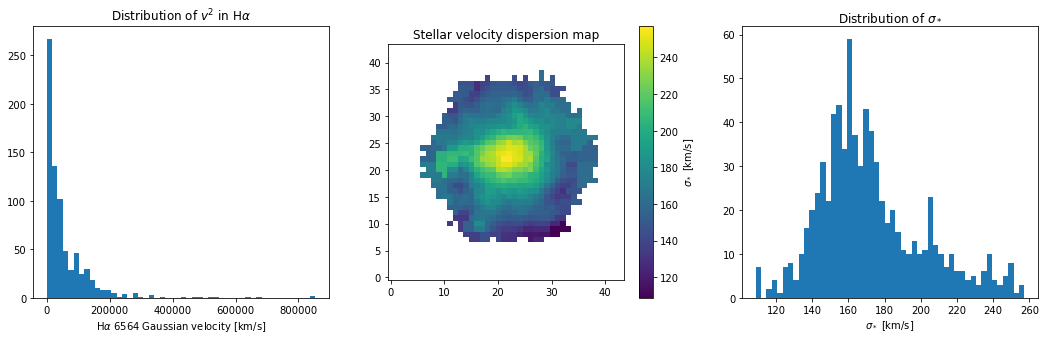

In [15]:
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.title(r'Distribution of $v^2$ in H$\alpha$')
plt.hist(mHa_vel.flatten()**2, bins=50)
plt.xlabel(r'H$\alpha$ 6564 Gaussian velocity [km/s]')

plt.subplot(132)
plt.title('Stellar velocity dispersion map')
plt.imshow(mStar_sigma, origin='lower')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\sigma_*$ [km/s]')

plt.subplot(133)
plt.title(r'Distribution of $\sigma_*$')
plt.hist(mStar_sigma.flatten(), bins=50)
plt.xlabel(r'$\sigma_*$ [km/s]')

Segev recommends that we use the median of the stellar velocity dispersion distribution for our mass calculations.

In [16]:
sigma_Ha = np.mean(mHa_vel*mHa_vel)

sigma_Ha

59150.18579234973

In [17]:
avg_star_sigma = np.nanmean(mStar_sigma)

median_star_sigma = ma.median(mStar_sigma)

# Convert from km/s to m/s
median_star_sigma_mpers = median_star_sigma*1000

median_star_sigma

166.4339

I should check this velocity dispersion against the Faber-Jackson relation.

For this galaxy, according to Figure 9 of Aguerri12, the median $\sigma_0$ is closer to the expected value for the velocity dispersion for a galaxy with this stellar mass than the central $\sigma_0$.

##### What if we use the velocity dispersion at the center of the galaxy?

In [18]:
# Center of galaxy is defined as the spaxel with the maximum luminosity
center_spaxel = np.unravel_index(ma.argmax(mr_band, axis=None), mr_band.shape)

center_star_sigma = mStar_sigma[center_spaxel]

# Convert from km/s to m/s
center_star_sigma_mpers = center_star_sigma*1000

center_star_sigma

257.1611

# Mass distribution

"\nplt.subplot(132)\nplt.title('Pipe3d stellar mass density')\nplt.imshow(sMass_density)\ncbar2 = plt.colorbar()\ncbar2.ax.set_ylabel(r'Stellar mass density [log($M_\\odot$)]')\n\nplt.subplot(133)\nplt.title('Pipe3d stellar mass-to-light ratio')\nplt.imshow(MtoL)\ncbar3 = plt.colorbar()\ncbar3.ax.set_ylabel(r'M/L [log($M_\\odot$/$L_\\odot$)]')\n"

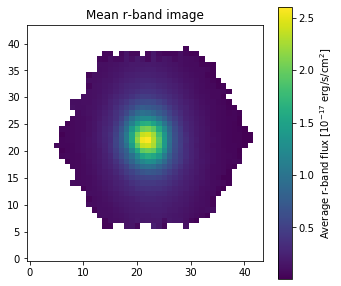

In [19]:
plt.figure(figsize=(18,5))

plt.subplot(131)
plt.title('Mean r-band image')
plt.imshow(mr_band, origin='lower')
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(r'Average r-band flux [10$^{-17}$ erg/s/cm$^2$]')
'''
plt.subplot(132)
plt.title('Pipe3d stellar mass density')
plt.imshow(sMass_density)
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel(r'Stellar mass density [log($M_\odot$)]')

plt.subplot(133)
plt.title('Pipe3d stellar mass-to-light ratio')
plt.imshow(MtoL)
cbar3 = plt.colorbar()
cbar3.ax.set_ylabel(r'M/L [log($M_\odot$/$L_\odot$)]')
'''

# Galaxy mass

We can use the virial theorem to calculate the total mass in an elliptical galaxy, since it is primarily supported by the stars' pressure rather than rotation.

\begin{equation}
  M \approx 2.5 \frac{\left< v^2 \right> r_h}{G} \approx 7.5 \frac{\sigma^2 r_h}{G}
\end{equation}

(Eqn. 20.17 from *Foundations of Astrophysics* by Ryden & Peterson) where $r_h$ is the half-light radius (really, the half-mass radius, but we cannot measure this).

So, first, we need to find $r_h$, presumably from the r-band image.

The total flux from the galaxy is not necessarily contained within the MaNGA footprint.  Ideally, then, we should use a total flux value from the legacy SDSS.  Then, we count out in consecutive annuli (using the NSA b/a, phi angles to start) until we reach 50% of this flux.  The resulting annulus is our $r_h$.

I have the 'NSA_index' in the master file, so I should be able to quickly extract other parameters from the NSA as needed.  At the moment, quantities that the NSA has that we might need for this analysis are:
* SERSICFLUX or nsa_sersic_flux - the 2D Sersic fit flux in FNugriz
* SERSIC_N or nsa_sersic_n - the 2D Sersic index
* SERSIC_BA or nsa_sersic_ba - the b/a axis ratio (already using)
* SERSIC_PHI or nsa_sersic_phi - the angle (E of N) of the major axis (already using)
* SERSIC_TH50 or nsa_sersic_th50 [arcsec] - 50% light radius along major axis from Sersic 2D fit

Or, we use the circular Petrosian fits:
* PETROTH50 or nsa_petro_th50 [arcsec] - 50% light radius from Petrosian fit

Or the **elliptical Petrosian** fits:
* **nsa_elpetro_th50_r**
* nsa_elpetro_ba
* nsa_elpetro_phi

## Locate galaxy in DRP table

In [18]:
gal_idx = general_data[1].data['plateifu'] == galaxy_ID

In [19]:
Mstar = general_data[1].data['nsa_elpetro_mass'][gal_idx] # Solar masses
z = general_data[1].data['z'][gal_idx]
r_half = general_data[1].data['nsa_elpetro_th50_r'][gal_idx] # arcsec

# Convert arcsec to kpc
r_half_kpc = (1000*c*z/H0)*np.tan(r_half*np.pi/(60*60*180))

# Convert kpc to m
r_half_m = 3.0857e19*r_half_kpc

## Calculate mass

In [20]:
def virial_mass(star_sigma, r_half):
    '''
    Calculate the virial mass of a galaxy
    
    PARAMETERS
    ==========
    
    star_sigma : float or numpy array
        Stellar velocity dispersion in m/s
        
    r_half : float or numpy array
        Half-light radius in m
        
    
    RETURNS
    =======
    
    Mvir_Msun : float or numpy array
        Virial mass in solar masses
    '''
    
    # Virial mass (in kg)
    Mvir = 7.5*star_sigma*star_sigma*r_half/G
    
    # Convert kg to Msun
    Mvir_Msun = Mvir/Msun
    
    return Mvir_Msun

#### Using median velocity dispersion

In [21]:
Mtot_Msun_median = virial_mass(median_star_sigma_mpers, r_half_m)

Mdark_median = Mtot_Msun_median - Mstar

#### Using central velocity dispersion

In [22]:
Mtot_Msun_center = virial_mass(center_star_sigma_mpers, r_half_m)

Mdark_center = Mtot_Msun_center - Mstar

# Mass ratio

In [23]:
MassRatio_median = Mdark_median/Mstar

MassRatio_median

array([1.51404181])

In [24]:
MassRatio_center = Mdark_center/Mstar

MassRatio_center

array([5.00204821])

In [25]:
np.log10(Mstar)

array([10.68767073])

In [26]:
np.log10(median_star_sigma)

2.2212417